In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
import glob
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
list_path = []
list_labels = []
TRAIN_PATH = "asl_filtered"


for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,asl_filtered\A\A1.jpg,A
1,asl_filtered\A\A1002.jpg,A
2,asl_filtered\A\A1007.jpg,A
3,asl_filtered\A\A1011.jpg,A
4,asl_filtered\A\A1016.jpg,A
...,...,...
15595,asl_filtered\Z\Z977.jpg,Z
15596,asl_filtered\Z\Z981.jpg,Z
15597,asl_filtered\Z\Z986.jpg,Z
15598,asl_filtered\Z\Z990.jpg,Z


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=0.3,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

# Create Final DataFrames
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})

In [4]:
label_to_index = {chr(ord('A') + i): i for i in range(26)}  # {'A': 0, 'B': 1, ..., 'Z': 25}

# Apply to your dataframes
data_train['label'] = data_train['label'].map(label_to_index)
data_val['label'] = data_val['label'].map(label_to_index)

In [5]:
data_train.head(10)

,image_path,label
7413,asl_filtered\M\M1958.jpg,12
5892,asl_filtered\J\J512.jpg,9
10184,asl_filtered\Q\Q927.jpg,16
10731,asl_filtered\R\R689.jpg,17
2891,asl_filtered\E\E508.jpg,4
352,asl_filtered\A\A2583.jpg,0
3736,asl_filtered\G\G1610.jpg,6
240,asl_filtered\A\A2079.jpg,0
14908,asl_filtered\Y\Y585.jpg,24
3456,asl_filtered\F\F350.jpg,5


In [6]:
data_val.head(10)

,image_path,label
6828,asl_filtered\L\L2024.jpg,11
9945,asl_filtered\Q\Q2551.jpg,16
5062,asl_filtered\I\I2178.jpg,8
15162,asl_filtered\Z\Z1728.jpg,25
11623,asl_filtered\T\T2001.jpg,19
8726,asl_filtered\O\O2466.jpg,14
4628,asl_filtered\H\H2925.jpg,7
8551,asl_filtered\O\O1679.jpg,14
4822,asl_filtered\I\I1098.jpg,8
5709,asl_filtered\J\J239.jpg,9


In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((data_train['image_path'].values, data_train['label'].values))
val_ds = tf.data.Dataset.from_tensor_slices((data_val['image_path'].values, data_val['label'].values))

In [8]:
IMG_SIZE = (200, 200)

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image/255.0
    return image, label

In [9]:
BATCH_SIZE = 32
train_ds = train_ds.map(process_image)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_ds = val_ds.map(process_image)
val_ds = val_ds.batch(BATCH_SIZE)

In [10]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [18]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

num_classes = data_train['label'].nunique()

base_model = InceptionV3(include_top=False, input_shape=(200, 200, 3), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
342/342 [==============================] - 30s 73ms/step - loss: 3.0269 - accuracy: 0.7058 - val_loss: 1.5357 - val_accuracy: 0.8276
Epoch 2/20
342/342 [==============================] - 24s 69ms/step - loss: 0.9358 - accuracy: 0.8842 - val_loss: 1.1459 - val_accuracy: 0.8788
Epoch 3/20
342/342 [==============================] - 24s 69ms/step - loss: 0.6560 - accuracy: 0.9222 - val_loss: 1.1197 - val_accuracy: 0.8912
Epoch 4/20
342/342 [==============================] - 24s 69ms/step - loss: 0.5119 - accuracy: 0.9446 - val_loss: 1.1557 - val_accuracy: 0.9034
Epoch 5/20
342/342 [==============================] - 24s 69ms/step - loss: 0.5465 - accuracy: 0.9459 - val_loss: 1.2232 - val_accuracy: 0.9073
Epoch 6/20
342/342 [==============================] - 24s 69ms/step - loss: 0.4788 - accuracy: 0.9538 - val_loss: 1.4079 - val_accuracy: 0.9011
Epoch 7/20
342/342 [==============================] - 24s 69ms/step - loss: 0.3843 - accuracy: 0.9632 - val_loss: 0.7657 - val_accuracy:

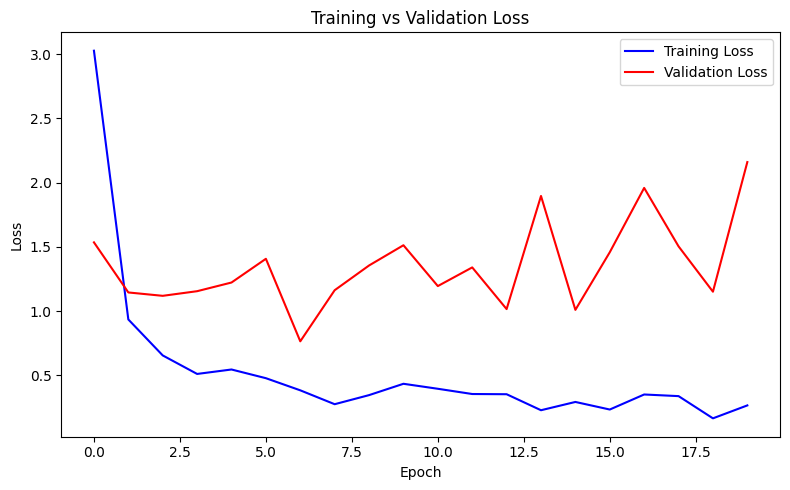

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(20)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

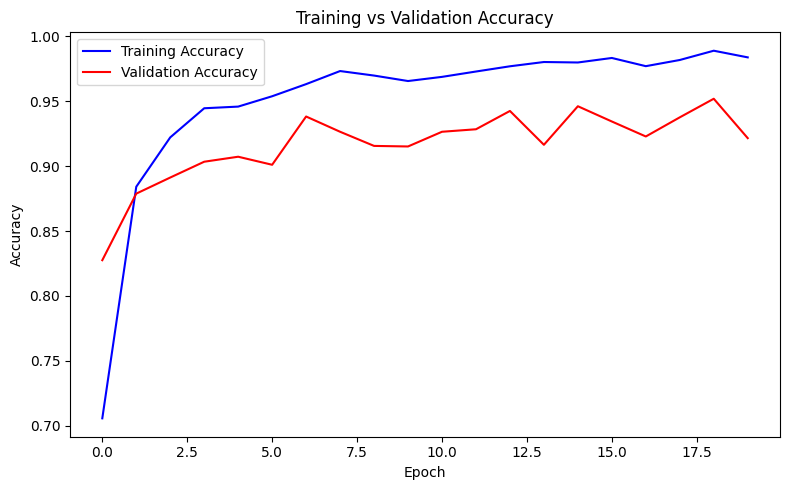

In [23]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()